In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import os
from PIL import Image
from ultralytics import YOLO
from ultralytics.nn.tasks import DetectionModel
from ultralytics.utils.loss import v8DetectionLoss
import json
import cv2
from tqdm import tqdm
from types import SimpleNamespace

In [2]:
def letterbox(img, boxes, new_shape=(640, 640), normalized=True):
    original_shape = img.shape[:2]
    ratio = min(new_shape[0] / original_shape[0], new_shape[1] / original_shape[1])
    new_unpad = (int(round(original_shape[1] * ratio)), int(round(original_shape[0] * ratio)))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]
    dw /= 2
    dh /= 2

    resized_img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    img_padded = cv2.copyMakeBorder(resized_img, int(dh), int(dh), int(dw), int(dw),
                                    borderType=cv2.BORDER_CONSTANT, value=(114, 114, 114))

    if normalized:
        boxes[:, 0] *= original_shape[1]
        boxes[:, 1] *= original_shape[0]
        boxes[:, 2] *= original_shape[1]
        boxes[:, 3] *= original_shape[0]

    boxes[:, 0] = boxes[:, 0] * ratio + dw  # x
    boxes[:, 1] = boxes[:, 1] * ratio + dh  # y
    boxes[:, 2] = boxes[:, 2] * ratio       # w
    boxes[:, 3] = boxes[:, 3] * ratio       # h

    if normalized:
        boxes[:, 0] /= new_shape[1]
        boxes[:, 1] /= new_shape[0]
        boxes[:, 2] /= new_shape[1]
        boxes[:, 3] /= new_shape[0]

    return img_padded, boxes

In [61]:
class YoloMapillaryDataset(Dataset):
    def __init__(self, images_path, labels_path, img_size=640, transform=None):
        self.images_path = images_path
        self.labels_path = labels_path
        self.img_size = img_size
        self.transform = transform
        self.image_files = [f for f in os.listdir(images_path) if f.endswith((".jpg", ".png"))]


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        img_path = os.path.join(self.images_path, self.image_files[index])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # load labels
        labels = []
        label_path = os.path.join(self.labels_path, os.path.splitext(self.image_files[index])[0] + '.txt')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    parts = list(map(float, line.strip().split()))
                    if len(parts) == 5:
                        labels.append(parts)

        labels = np.array(labels, dtype=np.float32)

        if len(labels) > 0:
            classes = labels[:, 0]
            boxes = labels[:, 1:]
        else:
            classes = np.array([], dtype=np.float32)
            boxes = np.zeros((0, 4), dtype=np.float32)

        img_padded, boxes = letterbox(img, boxes, new_shape=(self.img_size, self.img_size), normalized=True)

        img_tensor = torch.from_numpy(img_padded).permute(2, 0, 1).float() / 255.0
        boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
        classes_tensor = torch.tensor(classes, dtype=torch.int64)

        batch_idx_tensor = torch.full((len(boxes_tensor), 1), fill_value=0, dtype=torch.int64)

        return {
          'img': img_tensor,
          'bboxes': boxes_tensor,
          'cls': classes_tensor,
          'batch_idx': batch_idx_tensor
        }


In [100]:
from ultralytics.data.dataset import YOLODataset

# dataloader
images_path = 'dataset_light/images/'
labels_path = 'dataset_light/labels/'

train_dataset = YoloMapillaryDataset(
    images_path='dataset_light/images/train',
    labels_path='dataset_light/labels/train',
    img_size=640,
)

train_sz = int(len(train_dataset) * 0.2)
test_sz = len(train_dataset) - train_sz
train_dataset, test_dataset = random_split(train_dataset, [train_sz, test_sz])

val_dataset = YoloMapillaryDataset(
    images_path='dataset_light/images/val',
    labels_path='dataset_light/labels/val',
    img_size=640,
)

batch_size = 2
num_workers = 1

train_loader = DataLoader(
    train_dataset,
    #num_workers=num_workers,
    shuffle=True,
    collate_fn=YOLODataset.collate_fn,
)


val_loader = DataLoader(
    val_dataset,
    #num_workers=num_workers,
    shuffle=True,
    collate_fn=YOLODataset.collate_fn,
)

test_loader = DataLoader(
    test_dataset,
    shuffle=True,
    collate_fn=YOLODataset.collate_fn,
)

In [98]:
for item in enumerate(train_dataset):
    print(item)

(0, {'img': tensor([[[0.4471, 0.4471, 0.4471,  ..., 0.4471, 0.4471, 0.4471],
         [0.4471, 0.4471, 0.4471,  ..., 0.4471, 0.4471, 0.4471],
         [0.4471, 0.4471, 0.4471,  ..., 0.4471, 0.4471, 0.4471],
         ...,
         [0.4471, 0.4471, 0.4471,  ..., 0.4471, 0.4471, 0.4471],
         [0.4471, 0.4471, 0.4471,  ..., 0.4471, 0.4471, 0.4471],
         [0.4471, 0.4471, 0.4471,  ..., 0.4471, 0.4471, 0.4471]],

        [[0.4471, 0.4471, 0.4471,  ..., 0.4471, 0.4471, 0.4471],
         [0.4471, 0.4471, 0.4471,  ..., 0.4471, 0.4471, 0.4471],
         [0.4471, 0.4471, 0.4471,  ..., 0.4471, 0.4471, 0.4471],
         ...,
         [0.4471, 0.4471, 0.4471,  ..., 0.4471, 0.4471, 0.4471],
         [0.4471, 0.4471, 0.4471,  ..., 0.4471, 0.4471, 0.4471],
         [0.4471, 0.4471, 0.4471,  ..., 0.4471, 0.4471, 0.4471]],

        [[0.4471, 0.4471, 0.4471,  ..., 0.4471, 0.4471, 0.4471],
         [0.4471, 0.4471, 0.4471,  ..., 0.4471, 0.4471, 0.4471],
         [0.4471, 0.4471, 0.4471,  ..., 0.4471

In [99]:
from ultralytics.utils.loss import BboxLoss, TaskAlignedAssigner

class DetectionLoss(v8DetectionLoss):
  def __init__(self, model, hyp, tal_topk=10):
        device = next(model.parameters()).device
        h = hyp

        m = model.model[-1]
        self.bce = nn.BCEWithLogitsLoss(reduction="none")
        self.hyp = h
        self.stride = m.stride
        self.nc = m.nc
        self.no = m.nc + m.reg_max * 4
        self.reg_max = m.reg_max
        self.device = device

        self.use_dfl = m.reg_max > 1

        self.assigner = TaskAlignedAssigner(topk=tal_topk, num_classes=self.nc, alpha=0.5, beta=6.0)
        self.bbox_loss = BboxLoss(m.reg_max).to(device)
        self.proj = torch.arange(m.reg_max, dtype=torch.float, device=device)

In [64]:
# load model

model_checkpoint = torch.load('yolo11s.pt')
model_config = model_checkpoint['model'].yaml

model = DetectionModel(cfg=model_config, nc=243, verbose=True)
model.load(model_checkpoint)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)

Overriding model.yaml nc=80 with nc=243

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralyti

In [65]:
for param in model.parameters():
    param.requires_grad = False

for param in model.model[-1].parameters():
    param.requires_grad = True

for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Trainable: {name}")

Trainable: model.23.cv2.0.0.conv.weight
Trainable: model.23.cv2.0.0.bn.weight
Trainable: model.23.cv2.0.0.bn.bias
Trainable: model.23.cv2.0.1.conv.weight
Trainable: model.23.cv2.0.1.bn.weight
Trainable: model.23.cv2.0.1.bn.bias
Trainable: model.23.cv2.0.2.weight
Trainable: model.23.cv2.0.2.bias
Trainable: model.23.cv2.1.0.conv.weight
Trainable: model.23.cv2.1.0.bn.weight
Trainable: model.23.cv2.1.0.bn.bias
Trainable: model.23.cv2.1.1.conv.weight
Trainable: model.23.cv2.1.1.bn.weight
Trainable: model.23.cv2.1.1.bn.bias
Trainable: model.23.cv2.1.2.weight
Trainable: model.23.cv2.1.2.bias
Trainable: model.23.cv2.2.0.conv.weight
Trainable: model.23.cv2.2.0.bn.weight
Trainable: model.23.cv2.2.0.bn.bias
Trainable: model.23.cv2.2.1.conv.weight
Trainable: model.23.cv2.2.1.bn.weight
Trainable: model.23.cv2.2.1.bn.bias
Trainable: model.23.cv2.2.2.weight
Trainable: model.23.cv2.2.2.bias
Trainable: model.23.cv3.0.0.0.conv.weight
Trainable: model.23.cv3.0.0.0.bn.weight
Trainable: model.23.cv3.0.0.0.

In [110]:
# training loop

epochs = 1

loss_hyp = SimpleNamespace(
    box=0.05,
    cls=0.5,
    dfl=1.5
)

criterion = DetectionLoss(model, hyp=loss_hyp)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

total_loss = []
for epoch in range(epochs):
    training_loop = tqdm(train_loader, desc=f"Training epoch: {epoch+1}/{epochs}")

    epoch_loss = []
    for batch in training_loop:
        # batch = {key: val.to(device) for key, val in batch.items()}
        print(batch['cls'])
        break
        images = batch['img']
        
        # Forward
        output = model.forward(images)

        loss, loss_items = criterion(output, batch)
        loss = loss.sum()

        # Backward
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        epoch_loss.append(loss.item())

    total_loss.append(epoch_loss)

# print(total_loss)

Training epoch: 1/1:   0%|          | 0/2 [00:00<?, ?it/s]

tensor([ 82,  93,   6,   6,   6,  93, 131, 131])


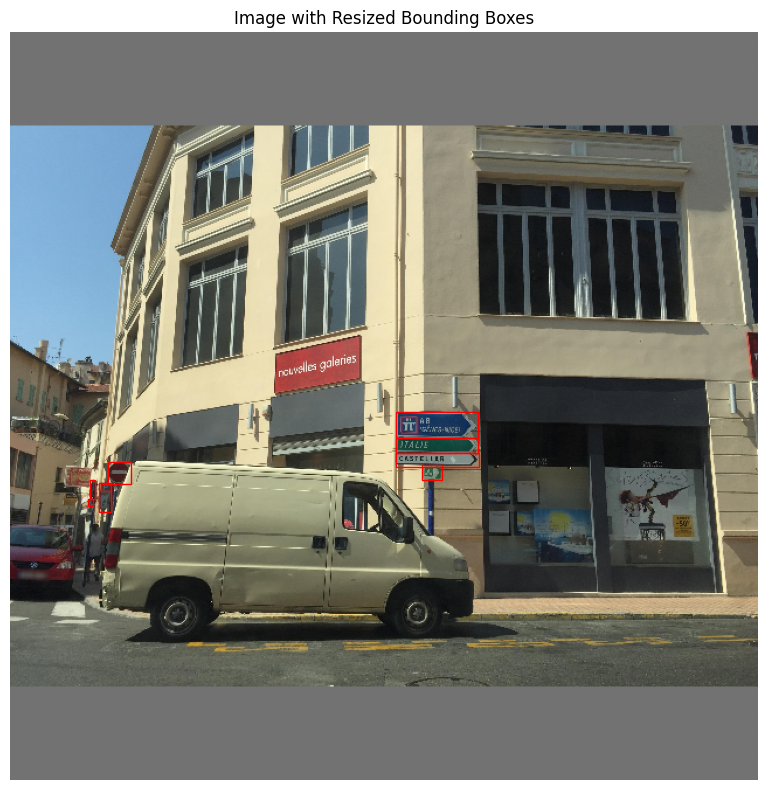

In [101]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

img_tensor, boxes_tensor, classes_tensor = dataset[3]

img_np = img_tensor.permute(1, 2, 0).numpy()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(img_np)

# draw each bounding box
for box in boxes_tensor:
    x_center, y_center, width, height = box.numpy()

    # convert xywh to top-left corner (x_min, y_min)
    x_min = (x_center - width / 2) * img_np.shape[1]
    y_min = (y_center - height / 2) * img_np.shape[0]
    box_w = width * img_np.shape[1]
    box_h = height * img_np.shape[0]

    # create a rectangle patch
    rect = patches.Rectangle((x_min, y_min), box_w, box_h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.title("Image with Resized Bounding Boxes")
plt.axis("off")
plt.tight_layout()
plt.show()
